In [1]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader

from models import KeyPointVAE
# from models import KeyPointVAEB as KeyPointVAE
from util_func import reparameterize, get_kp_mask_from_gmap
from playground_dataset import PlaygroundTrajectoryDataset
from mario_ds import MarioDataset

import matplotlib
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy.interpolate as inter
import numpy as np

In [5]:
def get_marker_style(i, cmap='Dark2'):
    cmap = plt.get_cmap(cmap)
    colors = [cmap(c) for c in np.linspace(0., 1., 8)]
#     markers = ['v', 'o', 's', 'd', '^', 'x', '+']
    markers =  7 * ['o']
    max_i = len(colors) * len(markers) - 1
    if i > max_i:
        raise ValueError('Exceeded maximum (' + str(max_i) + ') index for styles.')
    c = i % len(colors)
    m = int(i / len(colors))
    return colors[c], markers[m]


def single_marker_style(color, marker):
    return lambda _: (color, marker)


def plot_landmark(ax, landmark, k, size=1.5, zorder=2, cmap='Dark2',
                  style_fn=None):
    if style_fn is None:
        c, m = get_marker_style(k, cmap=cmap)
    else:
        c, m = style_fn(k)
#     ax.scatter(landmark[1], landmark[0], c=c, marker=m, facecolors='none',
#              s=(size * mpl.rcParams['lines.markersize']) ** 2,
#              zorder=zorder)
    ax.scatter(landmark[1], landmark[0], marker=m, facecolors='none', edgecolors=c)


def plot_landmarks(ax, landmarks, size=1.5, zorder=2, cmap='Dark2', style_fn=None, k_override=None):
    for k, landmark in enumerate(landmarks):
        if k_override is not None:
            k = k_override
            landmark = landmarks[k]
        plot_landmark(ax, landmark, k, size=size, zorder=zorder, cmap=cmap, style_fn=style_fn)

In [43]:
# hyper-parameters for model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_logsoftmax = False
# pad_mode = 'zeros'
pad_mode = 'reflect'
sigma = 0.1  # default sigma for the gaussian maps
dropout = 0.0
n_kp = 1  # num kp per patch
# n_kp_enc = 8  # total kp to output from the encoder / filter from prior
# n_kp_prior = 20  # total kp to filter from prior
# ds = 'celeb'
# ds = 'traffic'
ds = 'clevrer'
# ds = 'playground'
# ds = 'mario'

if ds == 'celeb':
    path_to_model_ckpt = './saves/best30_050122_131101_celeba_var_particles_gauss_pointnetpp_feat/saves/celeba_var_particles_gauss_pointnetpp_feat_best.pth'
    image_size = 128
    ch = 3
    enc_channels = [32, 64, 128, 256]
    prior_channels = (16, 32, 64)
    imwidth = 160
    crop = 16
    n_kp_enc = 30  # total kp to output from the encoder / filter from prior
    n_kp_prior = 50  # total kp to filter from prior
    use_object_enc = True
    use_object_dec = False
    learned_feature_dim = 10
    patch_size = 8  # 8 for playground, 16 for celeb
    dec_bone = "gauss_pointnetpp_feat"
elif ds == 'playground':
    # path_to_model_ckpt = './saves/playground_var_particles_gauss_pointnetpp_obj_enc_dec.pth'
    # path_to_model_ckpt = './230122_124452_playground_var_particles_gauss_pointnetpp/saves/playground_var_particles_gauss_pointnetpp.pth'  # best
    path_to_model_ckpt = './250122_095827_playground_var_particles_gauss_pointnetpp/saves/playground_var_particles_gauss_pointnetpp.pth'
    # path_to_model_ckpt = './saves/playground_var_particles_gauss_pointnetpp_obj_enc_dec_sep_kl.pth'
    image_size = 64
    ch = 3
    enc_channels = (16, 16, 32)
    prior_channels = enc_channels
    imwidth = 160
    crop = 16
    n_kp_enc = 8  # total kp to output from the encoder / filter from prior
    n_kp_prior = 20  # total kp to filter from prior
    use_object_enc = True
    use_object_dec = True
    learned_feature_dim = 10
    patch_size = 8  # 8 for playground, 16 for celeb
    anchor_s = 0.125
    dec_bone = "gauss_pointnetpp"
elif ds == 'traffic':
    path_to_model_ckpt = './saves/180122_165815_traffic_var_particles_gauss_pointnetpp/saves/traffic_var_particles_gauss_pointnetpp_best.pth'
    image_size = 128
    ch = 3
    enc_channels = [32, 64, 128, 256]
    prior_channels = (16, 32, 64)
    imwidth = 160
    crop = 16
    n_kp_enc = 15  # total kp to output from the encoder / filter from prior
    n_kp_prior = 50  # total kp to filter from prior
    use_object_enc = True
    use_object_dec = True
    learned_feature_dim = 20
    patch_size = 16
    anchor_s = 0.25
    dec_bone = "gauss_pointnetpp"
elif ds == 'clevrer':
    path_to_model_ckpt = './saves/clevrerf5_240122_095019_clevrer_var_particles_gauss_pointnetpp/saves/clevrer_var_particles_gauss_pointnetpp_best.pth'
    image_size = 128
    ch = 3
    enc_channels = [32, 64, 128, 256]
    prior_channels = (16, 32, 64)
    imwidth = 160
    crop = 16
    n_kp_enc = 10  # total kp to output from the encoder / filter from prior
    n_kp_prior = 50  # total kp to filter from prior
    use_object_enc = True
    use_object_dec = True
    learned_feature_dim = 5
    patch_size = 16
    anchor_s = 0.25
    dec_bone = "gauss_pointnetpp"
elif ds == 'mario':
    path_to_model_ckpt = './240122_152651_mario_var_particles_gauss_pointnetpp/saves/mario_var_particles_gauss_pointnetpp.pth'
    image_size = 128
    ch = 3
    enc_channels = [32, 64, 128, 256]
    prior_channels = (16, 32, 64)
    imwidth = 160
    crop = 16
    n_kp_enc = 30  # total kp to output from the encoder / filter from prior
    n_kp_prior = 50  # total kp to filter from prior
    use_object_enc = True
    use_object_dec = True
    learned_feature_dim = 32
    anchor_s = 0.25
    dec_bone = "gauss_pointnetpp"
else:
    raise NotImplementedError

kp_range = (-1, 1)
# kp_activation = "none"
# kp_activation = "sigmoid"
kp_activation = "tanh"
mask_threshold = 0.2
learn_order = False

In [44]:
model = KeyPointVAE(cdim=ch, enc_channels=enc_channels, prior_channels=prior_channels,
                    image_size=image_size, n_kp=n_kp, learned_feature_dim=learned_feature_dim,
                    use_logsoftmax=use_logsoftmax, pad_mode=pad_mode, sigma=sigma,
                    dropout=dropout, dec_bone=dec_bone, patch_size=patch_size, n_kp_enc=n_kp_enc,
                    n_kp_prior=n_kp_prior, kp_range=kp_range, kp_activation=kp_activation,
                    mask_threshold=mask_threshold, use_object_enc=use_object_enc,
                    use_object_dec=use_object_dec, anchor_s=anchor_s, learn_order=learn_order).to(device)
model.load_state_dict(torch.load(path_to_model_ckpt, map_location=device), strict=False)
# bn_eval(model)
model.eval()
print("loaded model from checkpoint")

decoder backbone: gauss_pointnetpp
prior std: 0.1
keypoints range: (-1, 1)
total number of kp: 64 -> prior kp: 50
number of kp from encoder: 10
kp_activation: tanh
learnable feature dim: 5
mask threshold: 0.2
object patch size: 32
object encoder: True, object decoder: True
learn particles order: False
conv shape:  torch.Size([256, 16, 16])
conv shape:  torch.Size([32, 8, 8])
conv shape:  torch.Size([64, 4, 4])
pointnet to cnn num upsample: 1
ObjDecCNN: fc to cnn num upsample: 2
loaded model from checkpoint


In [45]:
if ds == 'celeb':
    # load images
    images_path = ['../sample_images/070786.jpg', '../sample_images/190759.jpg',
                   '../sample_images/009151.jpg', '../sample_images/018905.jpg',
                   '../sample_images/025479.jpg', '../sample_images/051628.jpg',
                   '../sample_images/120346.jpg']
    images_t = []
    for i in range(len(images_path)):
        im = Image.open(images_path[i])
        # Move head up a bit
        vertical_shift = 30
        initial_crop = lambda im: transforms.functional.crop(im, 30, 0, 178, 178)
        initial_transforms = transforms.Compose([initial_crop, transforms.Resize(imwidth)])
        trans = transforms.ToTensor()
        im = trans(initial_transforms(im.convert("RGB")))
        if crop != 0:
            im = im[:, crop:-crop, crop:-crop]
        images_t.append(im)
    images_t = torch.stack(images_t, dim=0).to(device)
elif ds == 'mario':
    root = '/media/newhd/data/mario/mario_img128np_fs1.npy'
    mode = 'single'
    dataset = MarioDataset(path_to_npy=root, image_size=image_size, mode=mode, train=True)
    dataloader = DataLoader(dataset, shuffle=True, batch_size=1, num_workers=0, pin_memory=True,
                            drop_last=True)
    batch = next(iter(dataloader))
    if mode == 'single':
        x = batch
        x_prior = x
    else:
        x = batch[0].to(device)
        x_prior = batch[1].to
    # prev_obs, obs = prev_obs.to(device), obs.to(device)
    x = x.to(device)
    data = x
elif ds == 'traffic':
    images_path = ['../sample_images/101.png', '../sample_images/29974.png',
                   '../sample_images/76497.png']
    # path_to_image = '../sample_images/101.png'  # traffic 1
#         path_to_image = '../sample_images/29974.png'  # traffic 2
        # path_to_image = '../sample_images/57944.png'  # traffic 3
        # path_to_image = '../sample_images/76497.png'  # traffic 4
    images_t = []
    for i in range(len(images_path)):
        im = Image.open(images_path[i])
        im = im.convert('RGB')
        im = im.crop((60, 0, 480, 420))
        im = im.resize((image_size, image_size), Image.BICUBIC)
        trans = transforms.ToTensor()
        im = trans(im)
        images_t.append(im)
    images_t = torch.stack(images_t, dim=0).to(device)
elif ds == 'clevrer':
    images_path = ['../sample_images/clevr1.png', '../sample_images/clevr2.png',
                   '../sample_images/clevr7.png']
    images_t = []
    for i in range(len(images_path)):
        im = Image.open(images_path[i])
        im = im.convert('RGB')
        im = im.resize((image_size, image_size), Image.BICUBIC)
        trans = transforms.ToTensor()
        im = trans(im)
        images_t.append(im)
    images_t = torch.stack(images_t, dim=0).to(device)
else:
    raise NotImplementedError

In [46]:
images_t.shape

torch.Size([3, 3, 128, 128])

In [47]:
with torch.no_grad():
    deterministic = True
    enc_out = model.encode_all(images_t, return_heatmap=True, deterministic=deterministic)
    mu, logvar, kp_heatmap, mu_features, logvar_features, obj_on, order_weights = enc_out
    if deterministic:
        z = mu
        z_features = mu_features
    else:
        z = reparameterize(mu, logvar)
        z_features = reparameterize(mu_features, logvar_features)

    if learn_order:
        # _, order_weights = model.get_aux_dec(z, z_features)
        order_of_kp = [torch.argmax(order_weights[0][i]).item() for i in range(order_weights.shape[-1])]
        print(f'order of kp: {order_of_kp}')
    if obj_on is not None:
        print(f'obj_on: {obj_on[0].data.cpu()}')

    rec, dec_objects, dec_objects_trans = model.decode_all(z, z_features, kp_heatmap, obj_on,
                                                           deterministic=deterministic,order_weights=order_weights)
    rec = rec.clamp(0, 1)

obj_on: tensor([0.9999, 0.9998, 0.9987, 0.9995, 0.9956, 0.9892, 0.9984, 1.0000, 1.0000,
        0.9967])


In [48]:
# denormalize landmarks
landmarks = ((mu[:, :-1].data.cpu().numpy() + 1) / 2.0) * np.array(image_size - 1)
# images to numpy
images = images_t.permute(0, 2, 3, 1).data.cpu().numpy() * 255

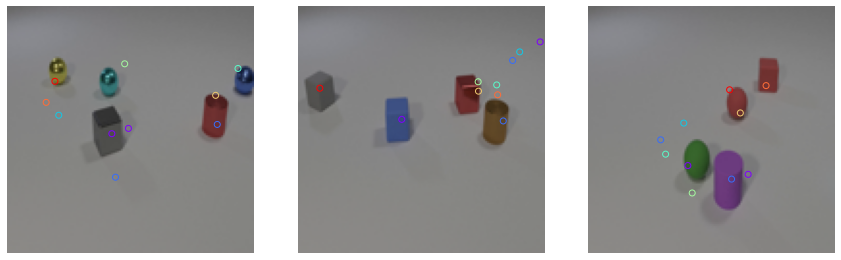

In [49]:
# clevrer
cols = min(4, len(images))
rows = int(np.ceil(len(images) / float(cols)))
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
for i, ax in enumerate(np.ravel(axs)):
    if i < len(images):
        ax.imshow(images[i].astype(np.uint8))
        plot_landmarks(ax, landmarks[i], size=3, cmap='rainbow', k_override=None)
    plt.tight_layout()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_axis_off()

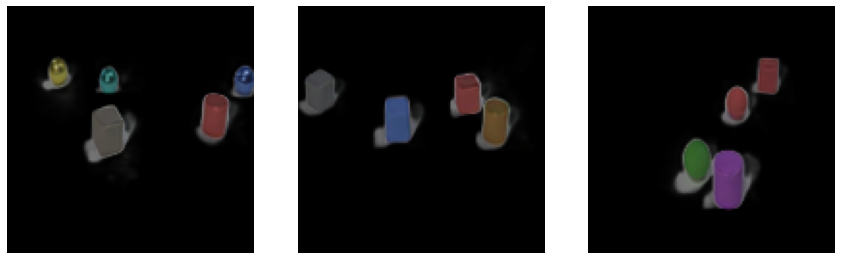

In [50]:
# images to numpy
objects_np = dec_objects_trans.permute(0, 2, 3, 1).data.cpu().numpy() * 255
cols = min(4, len(images))
rows = int(np.ceil(len(images) / float(cols)))
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
for i, ax in enumerate(np.ravel(axs)):
    if i < len(objects_np):
        ax.imshow(objects_np[i].astype(np.uint8))
    plt.tight_layout()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_axis_off()

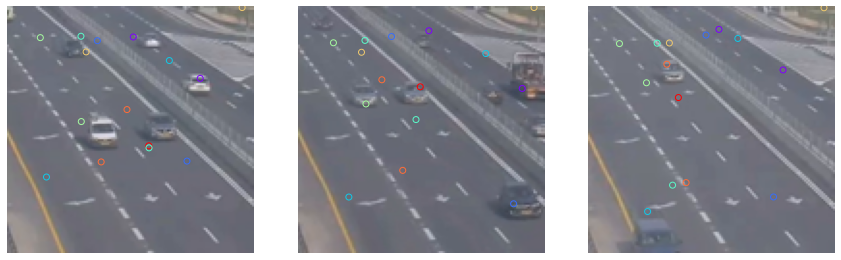

In [38]:
# traffic
cols = min(4, len(images))
rows = int(np.ceil(len(images) / float(cols)))
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
for i, ax in enumerate(np.ravel(axs)):
    if i < len(images):
        ax.imshow(images[i].astype(np.uint8))
        plot_landmarks(ax, landmarks[i], size=3, cmap='rainbow', k_override=None)
    plt.tight_layout()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_axis_off()# images to numpy
objects_np = dec_objects_trans.permute(0, 2, 3, 1).data.cpu().numpy() * 255
cols = min(4, len(images))
rows = int(np.ceil(len(images) / float(cols)))
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
for i, ax in enumerate(np.ravel(axs)):
    if i < len(objects_np):
        ax.imshow(objects_np[i].astype(np.uint8))
    plt.tight_layout()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_axis_off()

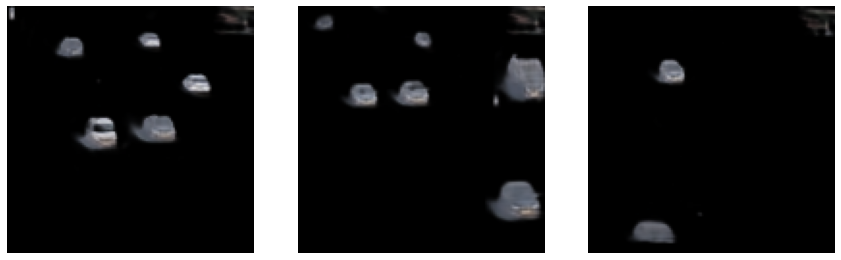

In [40]:
# images to numpy
objects_np = dec_objects_trans.permute(0, 2, 3, 1).data.cpu().numpy() * 255
cols = min(4, len(images))
rows = int(np.ceil(len(images) / float(cols)))
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
for i, ax in enumerate(np.ravel(axs)):
    if i < len(objects_np):
        ax.imshow(objects_np[i].astype(np.uint8))
    plt.tight_layout()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_axis_off()

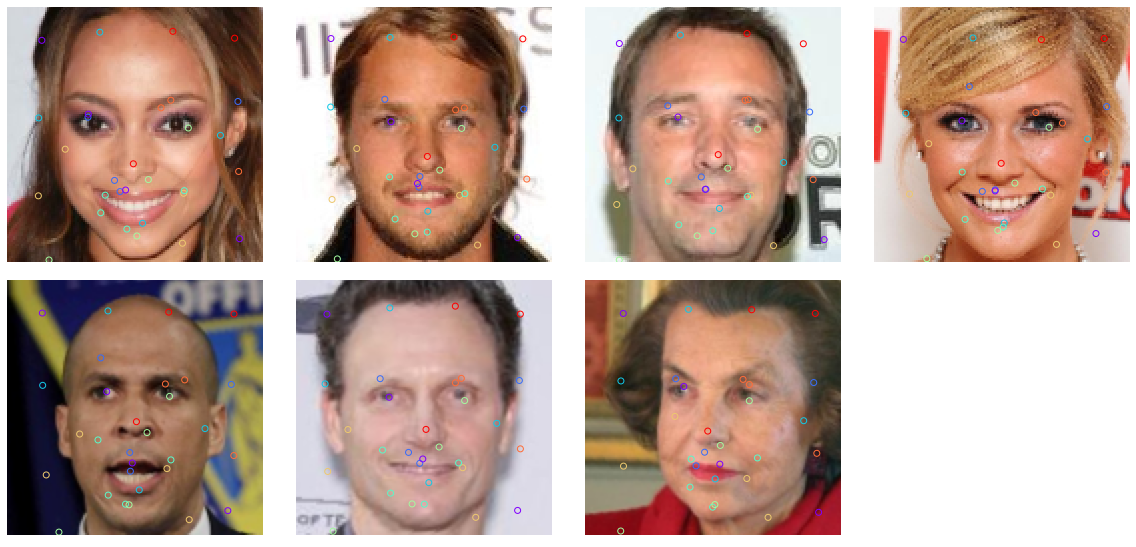

In [24]:
# celeb
cols = min(4, len(images))
rows = int(np.ceil(len(images) / float(cols)))
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
for i, ax in enumerate(np.ravel(axs)):
    if i < len(images):
        ax.imshow(images[i].astype(np.uint8))
        plot_landmarks(ax, landmarks[i], size=3, cmap='rainbow', k_override=None)
    plt.tight_layout()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_axis_off()